# BCS Demo using Local DYD Data
This demo plots the output data from an EnergyPlus model run with weather data specified by a DonateYourData file. 

In [1]:
import imp
import os
import logging

import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import plotly
import statsmodels

from BuildingControlsSimulator.Simulator.Simulator import Simulator
from BuildingControlsSimulator.Simulator.Config import Config
from BuildingControlsSimulator.BuildingModels.IDFPreprocessor import IDFPreprocessor
from BuildingControlsSimulator.BuildingModels.EnergyPlusBuildingModel import EnergyPlusBuildingModel
from BuildingControlsSimulator.ControllerModels.Deadband import Deadband

from BuildingControlsSimulator.DataClients.LocalSource import LocalSource
from BuildingControlsSimulator.DataClients.LocalDestination import LocalDestination
from BuildingControlsSimulator.DataClients.DataSpec import DonateYourDataSpec
from BuildingControlsSimulator.DataClients.DataClient import DataClient
from BuildingControlsSimulator.DataClients.GCSDYDSource import GCSDYDSource
from BuildingControlsSimulator.OutputAnalysis.OutputAnalysis import OutputAnalysis
from BuildingControlsSimulator.StateEstimatorModels.LowPassFilter import LowPassFilter

plotly.offline.init_notebook_mode(connected=True)
%load_ext autoreload
%autoreload 2

## Show EnergyPlus version

In [2]:
!energyplus --version

EnergyPlus, Version 9.4.0-998c4b761e


## Create a `DataClient` object for the simulation to read the input data

  The values in double quotes below are environment variables specified in the `.env` file.

In [8]:
dyd = DataClient(
    source=LocalSource(
        local_cache=os.environ.get("LOCAL_CACHE_DIR"),
        data_spec=DonateYourDataSpec(),
    ),
    destination=LocalDestination(
        local_cache=os.environ.get("LOCAL_CACHE_DIR"),
        data_spec=DonateYourDataSpec(),
    )
)

## Specify the DonateYourData file to read

The simulatin will run using the data in the file `${LOCAL_CACHE_DIR}/input/local/2756663bc57afe940c552ab1080f2ec09ef54e24.csv.zip`

Make sure this file exists. If it does not, copy it from your DonateYourData archive. 

In [4]:
sim_ids="2756663bc57afe940c552ab1080f2ec09ef54e24"

## Configure the simulator


In [5]:
sim_config = Config.make_sim_config(
    identifier=sim_ids,
    latitude=33.481136,
    longitude=-112.078232,
    start_utc="2018-07-05",
    end_utc="2018-07-10",
    min_sim_period="3D",
    sim_step_size_seconds=300,
    output_step_size_seconds=300,
)

## Specify building model

Read the `.idf` model *(e.g., one of the IECC Residential Prototype Building Models, or a model created in OpenStudio)*. 

The `IDFPreprocesor` can also override the specifications in the `.idf`. The follow override capabilities are currently implemented. 

In [ ]:
building_models = [
        EnergyPlusBuildingModel(
            idf=IDFPreprocessor(idf_file="../test/idf/v9-4-0/slab_1story_2000sqft_gasfurnace_AC.idf",
                building_config={
                    "infiltration_ventilation": {
                        # Adjusts infiltration ventilation rates according to ASHRAE Standard 62.2
                        "ach50": 8,
                        "wsf": 0.43,  # weather and shielding factor in Appendix B for site location
                    },
                    "insulation_r_si": {
                        # Modifies any `Construction` object in the IDF file to have the specified R-value
                        "Interior Ceiling": 5.3,  # °C⋅m2/W
                        "Exterior Wall": 2.0,  # °C⋅m2/W
                        "Exterior Floor": 1.8,  # °C⋅m2/W
                    },
                    "windows": {
                        # Modifies all `Window` objects in the IDF file with the following parameters
                        "u_factor": 1.2,
                        "solar_heat_gain": 0.20,
                        "visible_transmittance": 0.60,
                    },
                    "hvac": {
                        # "heating_stages": 1,  # "heating_stages" does not appear to be currently implemented in `IDFPreprocessor`
                        # "heating_equipment": "gas_furnace",  # "heating_stages" does not appear to be currently implemented in `IDFPreprocessor`
                        "heating_sizing_factor": 2.0,  # Scales the size of all heating systems
                        # "cooling_stages": 1,  # "cooling_stages" does not appear to be currently implemented in `IDFPreprocessor`
                        # "cooling_equipment": "dx_ac",  # "cooling_equipment" does not appear to be currently implemented in `IDFPreprocessor`
                        "cooling_sizing_factor": 2.0,  # Scales the size of all heating systems
                    },
                    "thermal_mass": 1e7,
                }
           ),
        )
    ]

## Initialize the simulator

In [ ]:
%%time
master = Simulator(
    data_client=dyd,
    sim_config=sim_config,
    building_models=building_models,
    state_estimator_models=[
        LowPassFilter(alpha_temperature=0.3, alpha_humidity=0.3)
    ],
    controller_models=[Deadband(deadband=1.0),],
)

In [7]:
%%time
# simulate
master.simulate(local=True, preprocess_check=False)

/home/bcs/lib/bcs_venv/lib/python3.8/site-packages/pandas/core/arrays/datetimelike.py:1108: PerformanceWarning:

Adding/subtracting object-dtype array to DatetimeArray not vectorized

/home/bcs/lib/bcs_venv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



CPU times: user 18.7 s, sys: 749 ms, total: 19.5 s
Wall time: 49 s


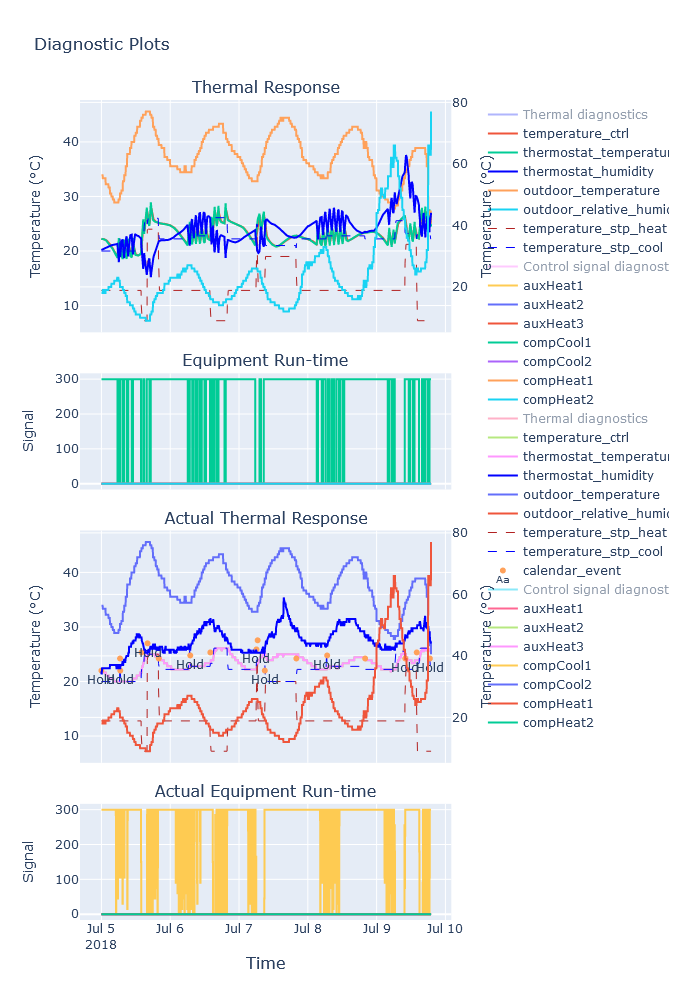

In [8]:
sim_analysis = OutputAnalysis(output_df=master.simulations[0].output, input_df=master.simulations[0].full_input, data_spec=dyd.internal_spec)
sim_analysis.diagnostic_plot(show=True, actuals=True)